# 1.Data Load

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#패키지
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns

import lightgbm as lgbm
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier

In [ ]:
#seed 고정
import random
import os
class CFG:
    SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED)

In [ ]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/sample_data/

/content/sample_data


In [ ]:
!unzip -qq '/content/drive/MyDrive/project_study_KKUL/004_유전체/open (1).zip'

In [ ]:
train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/test.csv')
snp = pd.read_csv('/content/sample_data/snp_info.csv')

sub = pd.read_csv('/content/sample_data/sample_submission.csv')

# 2.데이터 확인

## 1) train data 확인

In [ ]:
train.head()

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,...,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,0,0,0,2,G G,A G,A A,G A,C A,...,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,0,0,0,2,A G,A G,C A,A A,A A,...,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,0,0,0,2,G G,G G,A A,G A,C C,...,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_003,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G G,A G,G G,G G,G G,A A,G G,A
4,TRAIN_004,0,0,0,2,G G,G G,C C,A A,C C,...,A A,A A,A A,G G,A A,A A,A G,A A,G A,C


### (1) 결측치 확인

 * 결측치 없음을 확인할 수 있음

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      262 non-null    object
 1   father  262 non-null    int64 
 2   mother  262 non-null    int64 
 3   gender  262 non-null    int64 
 4   trait   262 non-null    int64 
 5   SNP_01  262 non-null    object
 6   SNP_02  262 non-null    object
 7   SNP_03  262 non-null    object
 8   SNP_04  262 non-null    object
 9   SNP_05  262 non-null    object
 10  SNP_06  262 non-null    object
 11  SNP_07  262 non-null    object
 12  SNP_08  262 non-null    object
 13  SNP_09  262 non-null    object
 14  SNP_10  262 non-null    object
 15  SNP_11  262 non-null    object
 16  SNP_12  262 non-null    object
 17  SNP_13  262 non-null    object
 18  SNP_14  262 non-null    object
 19  SNP_15  262 non-null    object
 20  class   262 non-null    object
dtypes: int64(4), object(17)
memory usage: 43.1+ KB


### (2) 데이터 구성 확인

* fater, mother, gender는 모두 값이 0인 것을 확인할 수 있음

In [ ]:
train.describe()

,father,mother,gender,trait
count,262.0,262.0,262.0,262.000000
mean,0.0,0.0,0.0,1.736641
std,0.0,0.0,0.0,0.441298
min,0.0,0.0,0.0,1.000000
25%,0.0,0.0,0.0,1.000000
50%,0.0,0.0,0.0,2.000000
75%,0.0,0.0,0.0,2.000000
max,0.0,0.0,0.0,2.000000


* train 데이터의 trait value 확인

In [ ]:
train['trait'].value_counts()

2    193
1     69
Name: trait, dtype: int64

* train 데이터의 class value 확인

In [ ]:
train['class'].value_counts()

B    114
C     79
A     69
Name: class, dtype: int64

* snp 열 별로 구성 데이터 확인

In [ ]:
# 데이터 구성(train)
snp_num1 = train.columns[train.columns.str.contains('SNP')].tolist()
for num1 in snp_num1:
  def count_into_lst(lst):
      answer=dict()
      for num in train[num1]:
          if num not in answer.keys():
              answer[num]=1
          else:
              answer[num]+=1
      return answer
  num_train1 =count_into_lst(train[num1])
  
  print(num_train1)

{'G G': 141, 'A G': 71, 'A A': 50}
{'A G': 97, 'G G': 108, 'A A': 57}
{'A A': 122, 'C A': 92, 'C C': 48}
{'G A': 93, 'A A': 120, 'G G': 49}
{'C A': 86, 'A A': 94, 'C C': 82}
{'A A': 61, 'A G': 122, 'G G': 79}
{'A A': 163, 'G G': 51, 'G A': 48}
{'G G': 79, 'G A': 96, 'A A': 87}
{'A A': 182, 'G A': 56, 'G G': 24}
{'G G': 151, 'A G': 68, 'A A': 43}
{'A G': 96, 'A A': 83, 'G G': 83}
{'A A': 136, 'G A': 73, 'G G': 53}
{'A A': 52, 'G G': 115, 'A G': 95}
{'A A': 185, 'C C': 23, 'C A': 54}
{'A A': 107, 'G G': 55, 'G A': 100}


## 2) test data 확인

In [ ]:
test.head()

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,TEST_000,0,0,0,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,A G,A G,G A,G G,C A,G A
1,TEST_001,0,0,0,2,G G,A G,C C,G G,C C,A A,A A,A A,A A,G G,A G,A A,A A,A A,A A
2,TEST_002,0,0,0,2,G G,A G,A A,A A,C A,A G,A A,A A,A A,A G,A A,G A,G G,A A,G G
3,TEST_003,0,0,0,2,G G,A G,C A,A A,C C,A A,A A,A A,A A,G G,A A,G A,A G,A A,A A
4,TEST_004,0,0,0,1,A A,G G,A A,G G,A A,G G,G G,A A,G G,A G,G G,G A,G G,A A,G G


### (1) 결측치 확인

 * 결측치 없음을 확인할 수 있음

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      175 non-null    object
 1   father  175 non-null    int64 
 2   mother  175 non-null    int64 
 3   gender  175 non-null    int64 
 4   trait   175 non-null    int64 
 5   SNP_01  175 non-null    object
 6   SNP_02  175 non-null    object
 7   SNP_03  175 non-null    object
 8   SNP_04  175 non-null    object
 9   SNP_05  175 non-null    object
 10  SNP_06  175 non-null    object
 11  SNP_07  175 non-null    object
 12  SNP_08  175 non-null    object
 13  SNP_09  175 non-null    object
 14  SNP_10  175 non-null    object
 15  SNP_11  175 non-null    object
 16  SNP_12  175 non-null    object
 17  SNP_13  175 non-null    object
 18  SNP_14  175 non-null    object
 19  SNP_15  175 non-null    object
dtypes: int64(4), object(16)
memory usage: 27.5+ KB


### (2) 데이터 구성 확인

* fater, mother, gender는 모두 값이 0인 것을 확인할 수 있음

In [ ]:
test.describe()

,father,mother,gender,trait
count,175.0,175.0,175.0,175.000000
mean,0.0,0.0,0.0,1.708571
std,0.0,0.0,0.0,0.455724
min,0.0,0.0,0.0,1.000000
25%,0.0,0.0,0.0,1.000000
50%,0.0,0.0,0.0,2.000000
75%,0.0,0.0,0.0,2.000000
max,0.0,0.0,0.0,2.000000


* train 데이터의 trait value 확인

In [ ]:
test['trait'].value_counts()

2    124
1     51
Name: trait, dtype: int64

* snp 열 별로 구성 데이터 확인

In [ ]:
# 데이터 구성(test)
snp_num2 = test.columns[test.columns.str.contains('SNP')].tolist()
for num2 in snp_num2:
  def count_into_lst(lst):
      answer=dict()
      for num in train[num2]:
          if num not in answer.keys():
              answer[num]=1
          else:
              answer[num]+=1
      return answer
  num_train2 =count_into_lst(test[num2])
  
  print(num_train2)

{'G G': 141, 'A G': 71, 'A A': 50}
{'A G': 97, 'G G': 108, 'A A': 57}
{'A A': 122, 'C A': 92, 'C C': 48}
{'G A': 93, 'A A': 120, 'G G': 49}
{'C A': 86, 'A A': 94, 'C C': 82}
{'A A': 61, 'A G': 122, 'G G': 79}
{'A A': 163, 'G G': 51, 'G A': 48}
{'G G': 79, 'G A': 96, 'A A': 87}
{'A A': 182, 'G A': 56, 'G G': 24}
{'G G': 151, 'A G': 68, 'A A': 43}
{'A G': 96, 'A A': 83, 'G G': 83}
{'A A': 136, 'G A': 73, 'G G': 53}
{'A A': 52, 'G G': 115, 'A G': 95}
{'A A': 185, 'C C': 23, 'C A': 54}
{'A A': 107, 'G G': 55, 'G A': 100}


## 3) SNP 확인

* SNP 데이터를 통해 파생 변수 생성에 필요한 정보를 확인 가능
  * 최소한의 SNP를 사용하는 것이 대회의 목적이기 때문에 SNP를 결합해 새로운 파생 변수를 만들 필요가 있음
  * 이 때 name, chrom, cm, pos를 바탕으로 어떤 SNP를 결합할 것인지 파악 가능

In [ ]:
snp

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


# 3.EDA

## 1) train 데이터의 class 구성 확인

<Axes: xlabel='class', ylabel='count'>

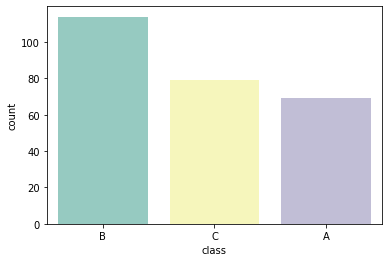

In [ ]:
sns.countplot(x = 'class', data = train, palette = 'Set3')

## 2) train 데이터의 trait 구성 확인

* class가 A이면 trait는 항상 1임
* class가 B,C면 trait는 항상 2임

<Axes: xlabel='trait', ylabel='count'>

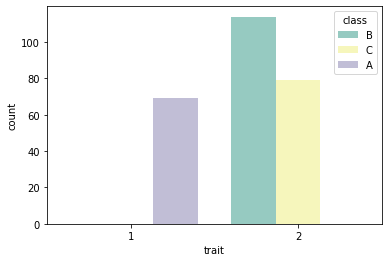

In [ ]:
sns.countplot(x = 'trait', hue = 'class', palette = 'Set3', data = train)

## 3) train 데이터의 snp 구성 요소 확인

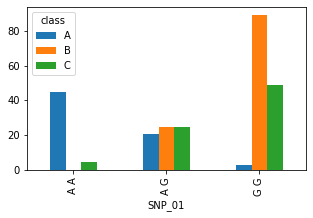

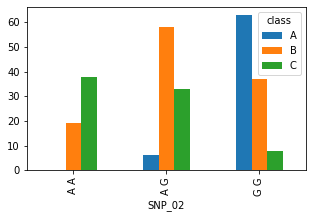

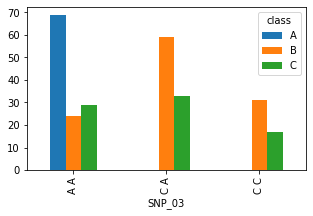

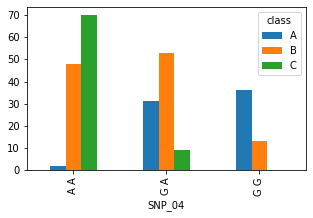

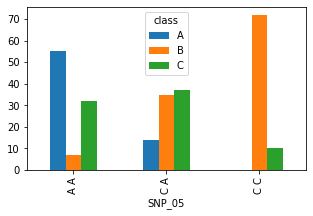

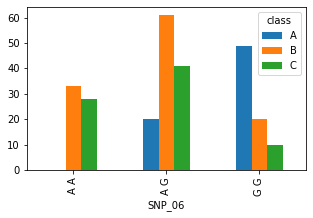

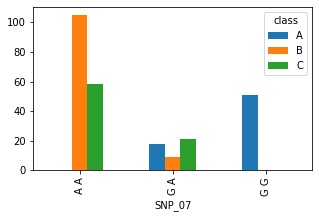

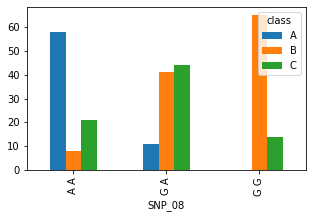

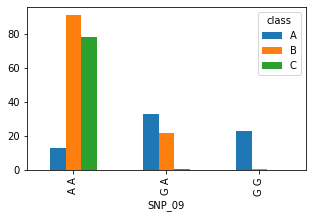

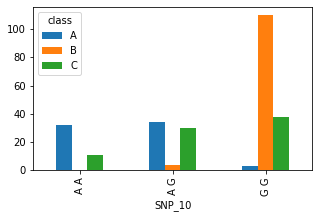

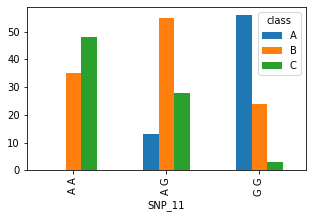

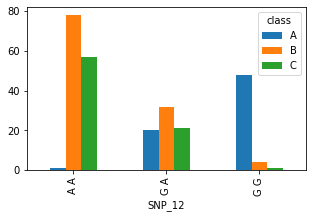

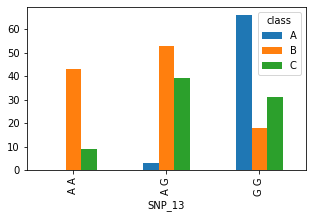

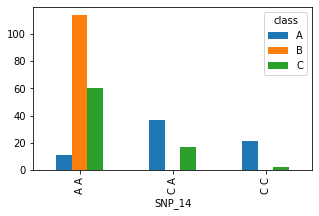

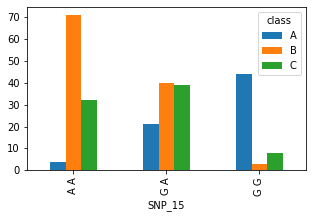

In [ ]:
snp_col = train.columns[train.columns.str.contains('SNP')].tolist()

for col in snp_col:
  train.groupby(col)['class'].value_counts().unstack().plot.bar(figsize = (5,3))
  temp = list(train.groupby(col)['class'].value_counts().sort_index())

## 4) SNP 데이터 cm과 pos 관계 그래프

* cm과 pos가 그래프 상 비슷한 구간에 위치할 경우, 같은 배열을 가진 것으로 판단


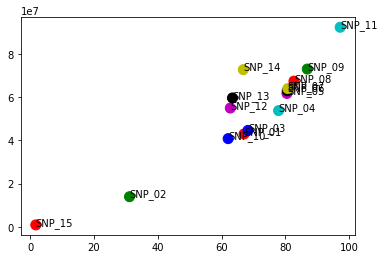

In [ ]:
#snp 중 cm과 pos 관계 그래프
X = snp['cm']
y = snp['pos']
plt.scatter(X,y,
            marker = 'o',
            s = 100,
            c = ['r','g','b','c','m','k','y','r','g','b','c','m','k','y','r']
            ) 
for X,y,name in zip(X,y,snp['SNP_id']):
  plt.text(X,y,name)
plt.show()

# 4.데이터 전처리

In [ ]:
# class 변수 A, B, C 각각 0,1,2로 변환
train['class'] = train['class'].map({'A':0, 'B':1, 'C':2}).astype(int)

* 변수를 숫자형으로 변환할 때 Label encoding을 사용하지 않은 이유
  * 파생 변수를 생성할 때 생길 혼란을 방지하기 위함
  * 예를 들어, AA와 GG를 결합하면 AA GG 가 생성됨. AA = 1, GG = 11 이기 때문에 결합시 12가 됨. 하지만 AA = 1, GG = 2일 경우 결합하면 AA GG는 3이 되기 때문에 기존에 있던 3과 혼동을 유발할 수 있음

In [ ]:
# 변수 변환
snp_col = train.columns[train.columns.str.contains('SNP')].tolist()
for col in snp_col:
  train[col] = train[col].map(
      {'A A':1, 'G G':11, 'A G':111, 'G A':1111, 
       'C C':11111, 'A C':111111, 'C A':1111111}).astype(int)
  test[col] = test[col].map(
      {'A A':1, 'G G':11, 'A G':111, 'G A':1111, 
       'C C':11111, 'A C':111111, 'C A':1111111}).astype(int)

## 1) 상관관계 확인

* SNP 변수를 숫자 형태로 변환 후 상관 관계 확인
* 최소한의 SNP를 사용하여 정확도를 높이는 것이 목표이기 때문에 상관 관계를 확인함
  * trait, class 변수와 각각 SNP의 상관 계수를 확인하여 영향이 낮은 SNP 탐색  
   -> SNP_1, SNP_6, SNP_12는 trait 변수와 class 변수 둘 다 상관 계수가 낮음

<Axes: >

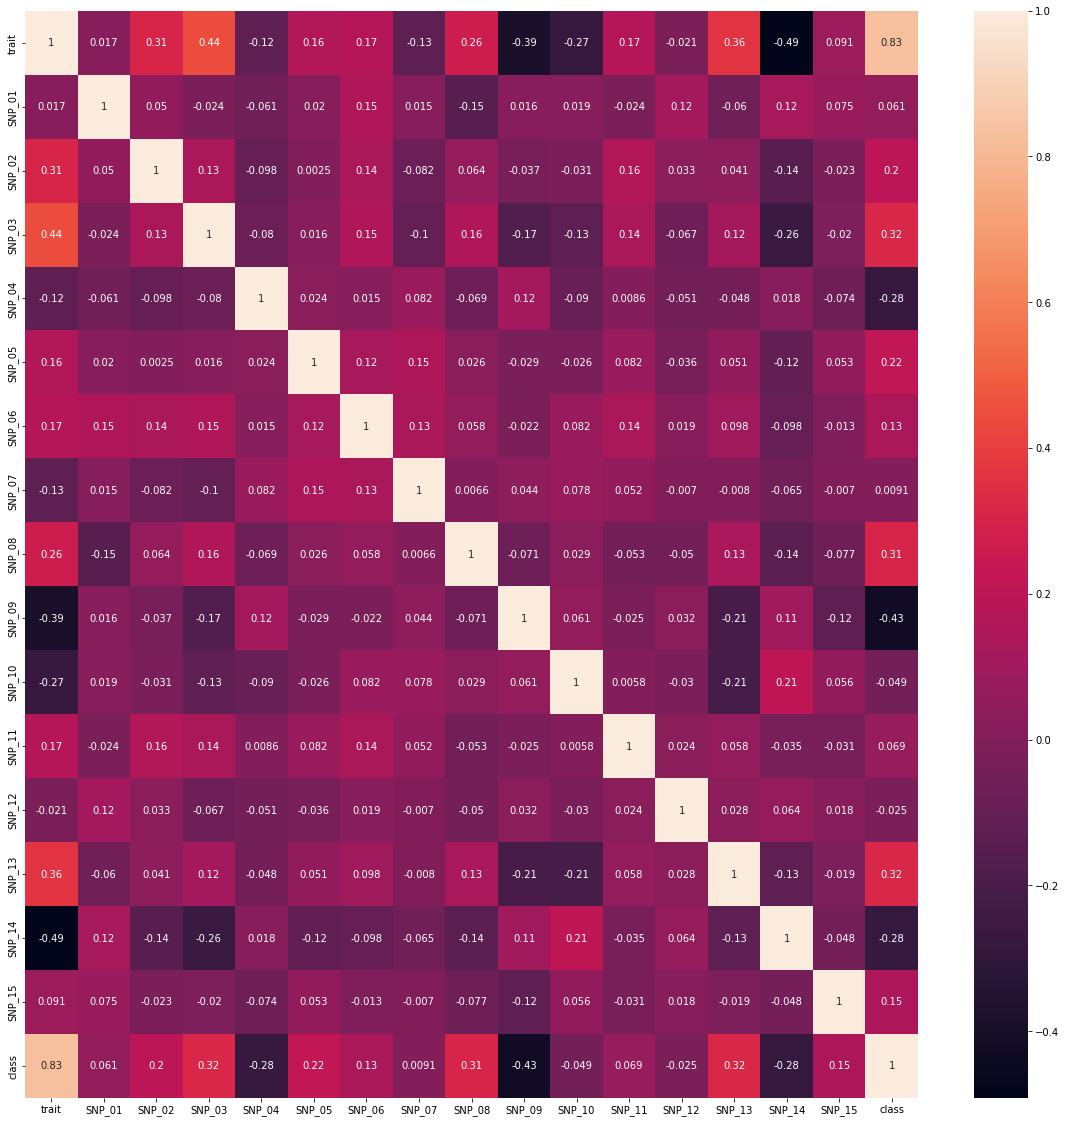

In [ ]:
# train의 변수 간 상관관계/상관계수 확인
corr_data = train.drop(['id', 'father', 'mother', 'gender'], axis = 1)
plt.figure(figsize=(20,20))
sns.heatmap(data = corr_data.corr(), annot=True)

# 5.Feature Engineering

* cm, pos가 비슷한 SNP_10과 SNP_13을 결합
* heatmap을 통해 class와 상관 관계가 낮은 SNP를 일부 삭제함 

In [ ]:
# 파생변수 생성
train['SNP_1013'] = train['SNP_10'] + train['SNP_13']
test['SNP_1013'] = test['SNP_10'] + test['SNP_13']

In [ ]:
#변수 선택
X_train = train.drop(['id', 'father', 'mother', 'gender','class','SNP_01','SNP_06','SNP_10','SNP_12','SNP_13'], axis = 1)
y_train = train['class']
X_test = test.drop(['id', 'father', 'mother', 'gender','SNP_01','SNP_06','SNP_10','SNP_12','SNP_13'], axis = 1)

In [ ]:
X_train.head()

,trait,SNP_02,SNP_03,SNP_04,SNP_05,SNP_07,SNP_08,SNP_09,SNP_11,SNP_14,SNP_15,SNP_1013
0,2,111,1,1111,1111111,1,11,1,111,1,1,12
1,2,111,1111111,1,1,1,1111,1,1,1,1,122
2,2,11,1,1111,11111,1,1111,1111,1,1,1,112
3,1,11,1,1111,1,11,1,11,11,1,11,122
4,2,11,11111,1,11111,1,1,1,1,1,1111,122


# 6.Modeling

In [ ]:
# train_x, train_y, test_x 형태 확인
X_train.shape, y_train.shape, X_test.shape

((262, 12), (262,), (175, 12))

In [ ]:
#lightGBM, ExtraTreesClassifier, RandomForestClassifier 선택
model = lgbm.LGBMClassifier()

et_cls = ExtraTreesClassifier(n_estimators=500, min_samples_leaf=5, min_samples_split=7, max_features=12)
rf_cls = RandomForestClassifier(n_estimators=500, min_samples_leaf=5, min_samples_split=7, max_features=12)
lg_cls = model.fit(X_train,y_train)

# 모델 voting
voting = VotingClassifier(
    estimators=[
        ('et', et_cls),
        ('rf', rf_cls),
        ('lg', lg_cls)
    ]
)
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(max_features=12,
                                                   min_samples_leaf=5,
                                                   min_samples_split=7,
                                                   n_estimators=500)),
                             ('rf',
                              RandomForestClassifier(max_features=12,
                                                     min_samples_leaf=5,
                                                     min_samples_split=7,
                                                     n_estimators=500)),
                             ('lg', LGBMClassifier())])

# 7.Predict

In [ ]:
pred = voting.predict(X_test)
sub['class'] = pred

# 해당하는 class로 변환
sub['class'] = sub['class'].map({0:'A', 1:'B', 2:'C'}).astype(object)

In [ ]:
sub.head()

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,C
4,TEST_004,A


In [ ]:
# pred 값 확인
sub['class'].value_counts()

B    85
A    51
C    39
Name: class, dtype: int64

In [ ]:
# 저장
sub.to_csv("/content/sample_data/answer.csv", index = False)